# 1. MMDetection 설치 및 Kitti 데이터셋 다운로드

## MMDetection 설치

In [ ]:
# MMCV 설치
# torch 버전이 달라지면 달라진 버전을 입력해주어야 함
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
# MMDetection git clolne
!git clone https://github.com/open-mmlab/mmdetection.git
# MMDetection 설치
!cd mmdetection; python setup.py install

In [ ]:
# 임포트하기 전에 '런타임 다시 시작'을 해야 함
from mmdet.apis import init_detector, inference_detector
import mmcv

## Kitti 데이터셋 다운로드

In [ ]:
# 튜토리얼용인 저용량 Kitti 데이터셋 다운로드하고 /content 밑에 압축 해제
!wget https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
!unzip kitti_tiny.zip > /dev/null

--2022-03-19 15:15:39--  https://download.openmmlab.com/mmdetection/data/kitti_tiny.zip
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6918271 (6.6M) [application/zip]
Saving to: ‘kitti_tiny.zip’

kitti_tiny.zip      100%[===================>]   6.60M  11.2MB/s    in 0.6s    

2022-03-19 15:15:41 (11.2 MB/s) - ‘kitti_tiny.zip’ saved [6918271/6918271]



## Kitti 데이터 둘러보기

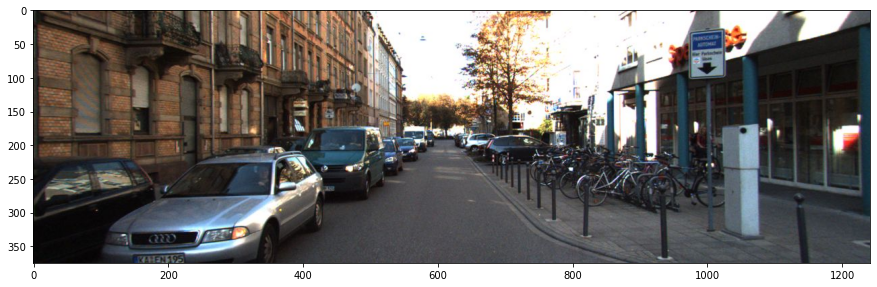

In [ ]:
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 10))
plt.imshow(img);

#### 포맷 확인
* 첫 번째 열이 해당 객체 클래스명
* 5번째~8번째 열이 경계 박스 좌표값(좌상단(x_min, y_min), 우하단(x_max, y_max))

In [ ]:
!cat /content/kitti_tiny/training/label_2/000068.txt

Car 0.25 0 1.94 69.26 200.28 435.08 374.00 1.46 1.62 4.04 -3.00 1.79 6.98 1.55
Car 0.80 1 2.26 0.00 209.20 198.59 374.00 1.46 1.58 3.72 -5.44 1.85 6.22 1.56
Cyclist 0.97 0 2.34 1210.28 199.77 1241.00 374.00 1.55 0.57 1.73 4.04 1.69 3.57 -3.14
Car 0.00 2 1.68 478.18 187.68 549.54 249.43 1.57 1.60 3.99 -2.73 2.03 20.96 1.55
Car 0.00 1 1.66 530.03 187.79 573.10 226.09 1.52 1.54 3.68 -2.53 2.20 31.50 1.58
Van 0.00 1 1.63 547.61 171.12 584.05 212.41 2.47 1.98 5.81 -2.79 2.41 46.44 1.57
Car 0.00 1 -0.16 667.74 182.35 790.82 230.38 1.62 1.65 4.14 4.19 1.99 25.95 0.00
Car 0.00 2 -0.11 657.37 184.48 763.34 221.64 1.55 1.66 4.47 4.35 2.10 32.00 0.02
Car 0.00 1 -0.01 637.45 180.34 714.44 212.34 1.69 1.76 4.12 3.59 2.12 39.79 0.08
Van 0.00 1 1.61 572.52 175.02 596.26 199.95 2.13 1.91 6.40 -2.28 2.36 65.43 1.57
Van 0.00 1 1.77 380.78 167.69 523.29 288.56 1.95 1.75 4.63 -2.89 1.90 14.05 1.57
Cyclist 0.00 1 1.09 958.95 167.55 1036.88 254.43 1.68 0.53 1.96 7.95 1.59 14.95 1.57


### Kitti annotation 파일들의 리스트를 갖는 파일 확인

In [ ]:
!cat /content/kitti_tiny/train.txt

000000
000001
000002
000003
000004
000005
000006
000007
000008
000009
000010
000011
000012
000013
000014
000015
000016
000017
000018
000019
000020
000021
000022
000023
000024
000025
000026
000027
000028
000029
000030
000031
000032
000033
000034
000035
000036
000037
000038
000039
000040
000041
000042
000043
000044
000045
000046
000047
000048
000049


# 2. kitti 데이터셋을 중립 데이터 형태로 변환하는 CustomDataset 정의

In [ ]:
import copy
import os
import mmcv
import numpy as np
from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

@DATASETS.register_module(force=True) # KittyTinyDataset 객체를 MMDetection 프레임워크에 등록 ---①
class KittyTinyDataset(CustomDataset): # CustomDataset을 상속받은 클래스 생성 ---②
  CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist') # 클래스 레이블 지정 ---③

  # CustomDataset의 load_annotations를 오버라이딩(재정의) ---④
  def load_annotations(self, ann_file): 
    # 이미 상속받은 초기화 인자 출력 ---⑤
    print('## self.data_root:', self.data_root, 'self.ann_file:', self.ann_file, 'self.img_prefix:', self.img_prefix)
    print('## ann_file:', ann_file)
    ## self.data_root: /content/kitti_tiny/ 
    ## self.ann_file: /content/kitti_tiny/train.txt 
    ## self.img_prefix: /content/kitti_tiny/training/image_2
    ## ann_file: /content/kitti_tiny/train.txt
    
    cat2label = {k:i for i, k in enumerate(self.CLASSES)} # {클래스명: 클래스ID}로 구성된 딕셔너리 ---⑥
    image_id_list = mmcv.list_from_file(self.ann_file) # 이미지ID 리스트 
    data_infos = [] # 포맷 중립 데이터를 담을 리스트 객체
    
    # image_id_list를 순회하며 이미지마다 포맷 중립 데이터로 변환 ---⑦
    for image_id in image_id_list:
      filename = f'{self.img_prefix}/{image_id}.jpeg' # 파일명
      # filename 이미지를 직접 불러와 원본 이미지의 너비, 높이 구하기 
      img = cv2.imread(filename)
      height, width = img.shape[0], img.shape[1] # 이미지 높이와 너비
      
      # 개별 이미지의 annotation 정보 저장용 딕셔너리 생성 ---⑧
      data_info = {'filename': str(image_id) + '.jpeg', # 파일명(확장자 포함)
                   'width': width,   # 이미지 너비
                   'height': height} # 이미지 높이

      # annotation prefix ---⑨
      # label_prefix = '/content/kitti_tiny/training/label_2'
      label_prefix = self.img_prefix.replace('image_2', 'label_2')
      # 개별 annotation 파일을 한 line 씩 읽어서 list 로드 ---⑩
      lines = mmcv.list_from_file(os.path.join(label_prefix, str(image_id)+'.txt'))

      # 개별 line을 공백 기준으로 parsing해 다시 list로 저장. content는 리스트의 리스트 형태 ---⑪
      content = [line.strip().split(' ') for line in lines]
      bboxes = [ [float(info) for info in x[4:8]] for x in content] # 경계 박스 좌표
      labels = [x[0] for x in content] # 객체 클래스명

      gt_bboxes = []        # 실제 경계 박스
      gt_labels = []        # 실제 클래스 레이블명
      gt_bboxes_ignore = [] # 훈련에 사용하지 않을 경계 박스
      gt_labels_ignore = [] # 훈련에 사용하지 않을 클래스 레이블명

      # 경계 박스와 클래스 레이블명 저장 ---⑫
      for label, bbox in zip(labels, bboxes):
        if label in cat2label:
          gt_bboxes.append(bbox)
          gt_labels.append(cat2label[label]) # gt_labels에는 class id를 저장 (ex. 0, 1, 2, 3)
        else:
          gt_bboxes_ignore.append(bbox)
          gt_labels_ignore.append(-1)

      # 이미지별 annotation 정보를 갖는 딕셔너리 생성 ---⑬
      anno = {
          'bboxes': np.array(gt_bboxes, dtype=np.float32).reshape(-1, 4),
          'labels': np.array(gt_labels, dtype=np.long),
          'bboxes_ignore': np.array(gt_bboxes_ignore, dtype=np.float32).reshape(-1, 4),
          'labels_ignore': np.array(gt_labels_ignore, dtype=np.long)
          }
      data_info.update(ann=anno) # data_info에 anno 정보 업데이트 ---⑭
      data_infos.append(data_info) # data_infos에 data_info 추가 ---⑮

    return data_infos # 중립 데이터 형태로 변환한 데이터셋 반환

# 3. config 설정

In [ ]:
# 사전 훈련 모델을 다운로드 받기 위해 mmdetection/checkpoints 디렉터리 생성 
!cd mmdetection; mkdir checkpoints
# 사전 훈련된 Faster R-CNN 다운로드
!wget -O /content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth

--2022-03-19 15:15:42--  http://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 167287506 (160M) [application/octet-stream]
Saving to: ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’

/content/mmdetectio 100%[===================>] 159.54M  10.7MB/s    in 16s     

2022-03-19 15:15:59 (9.73 MB/s) - ‘/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth’ saved [167287506/167287506]



In [ ]:
# config 파일 설정
config_file = '/content/mmdetection/configs/faster_rcnn/faster_rcnn_r50_fpn_1x_coco.py'
# 다운로드 받은 사전 훈련 모델을 checkpoint로 설정
checkpoint_file = '/content/mmdetection/checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

In [ ]:
from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.

In [ ]:
from mmdet.apis import set_random_seed

# 데이터셋의 환경 파라미터 수정
cfg.dataset_type = 'KittyTinyDataset'
cfg.data_root = '/content/kitti_tiny/'

# train, val, test 데이터셋에 대한 type, data_root, ann_file, img_prefix 환경 파라미터 수정
cfg.data.train.type = 'KittyTinyDataset'
cfg.data.train.data_root = '/content/kitti_tiny/'
# MMDetection 요구에 따라 annotation 파일은 하나여야 함. 그래서 label_2 디렉터리가 아님 ---①
cfg.data.train.ann_file = 'train.txt' 
cfg.data.train.img_prefix = 'training/image_2' # 디렉터리

cfg.data.val.type = 'KittyTinyDataset'
cfg.data.val.data_root = '/content/kitti_tiny/'
cfg.data.val.ann_file = 'val.txt'
cfg.data.val.img_prefix = 'training/image_2'

cfg.data.test.type = 'KittyTinyDataset'
cfg.data.test.data_root = '/content/kitti_tiny/'
cfg.data.test.ann_file = 'val.txt'
cfg.data.test.img_prefix = 'training/image_2'

# 클래스 개수 수정 (초기값=80) ---②
cfg.model.roi_head.bbox_head.num_classes = 4
# 사전 훈련 모델 (상대 경로이므로 root 디렉터리 = mmdetection) ---③
cfg.load_from = 'checkpoints/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# 학습 weight 파일로 로그를 저장하기 위한 디렉터리 설정 (상대 경로) ---④
cfg.work_dir = './tutorial_exps'

cfg.optimizer.lr = 0.02 / 8 # 학습률 변경 환경 파라미터 설정 
cfg.lr_config.warmup = None # 웜업 미설정
cfg.log_config.interval = 10 # 로그 출력 인터벌 ---⑤

# config 설정 시마다 policy값이 없어지는 버그 때문에 재설정 ---⑥
cfg.lr_config.policy = 'step'
# 커스텀 데이터셋을 사용하므로 그에 따른 평가 지표로 수정
cfg.evaluation.metric = 'mAP'
# 평가 인터벌 설정 (평가 시간을 줄이기 위해) ---⑦
cfg.evaluation.interval = 12
# 체크포인트 인터벌 설정 (저장 용량을 줄이기 위해) ---⑧
cfg.checkpoint_config.interval = 12

In [ ]:
# 훈련 파이프라인 파라미터 설정
cfg.data.train.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(type='LoadAnnotations', with_bbox=True),
            dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
        ]

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='Resize', img_scale=(1500, 900), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels'])
]

# 검증/테스트 파이프라인 파라미터 설정
cfg.data.val.pipeline=[
            dict(type='LoadImageFromFile'),
            dict(
                type='MultiScaleFlipAug',
                img_scale=(1500, 900),
                flip=False,
                transforms=[
                    dict(type='Resize', keep_ratio=True),
                    dict(type='RandomFlip'),
                    dict(
                        type='Normalize',
                        mean=[123.675, 116.28, 103.53],
                        std=[58.395, 57.12, 57.375],
                        to_rgb=True),
                    dict(type='Pad', size_divisor=32),
                    dict(type='ImageToTensor', keys=['img']),
                    dict(type='Collect', keys=['img'])
                ])
        ]
  
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500, 900),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(
                type='Normalize',
                mean=[123.675, 116.28, 103.53],
                std=[58.395, 57.12, 57.375],
                to_rgb=True),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img'])
        ])
]

# 결과 재현을 위한 시드값 설정
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='FasterRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[8],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, loss_w

# 4. 모델 훈련

In [ ]:
from mmdet.datasets import build_dataset

# config에 설정된 주요 값으로 CustomDataset 생성 (훈련용 데이터셋)
datasets = [build_dataset(cfg.data.train)] 

## self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/train.txt self.img_prefix: /content/kitti_tiny/training/image_2
## ann_file: /content/kitti_tiny/train.txt


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

In [ ]:
datasets

[
 KittyTinyDataset Train dataset with number of images 50, and instance counts: 
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | category | count | category  | count | category       | count | category    | count | category      | count |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+
 | 0 [Car]  | 147   | 1 [Truck] | 7     | 2 [Pedestrian] | 23    | 3 [Cyclist] | 7     | -1 background | 0     |
 +----------+-------+-----------+-------+----------------+-------+-------------+-------+---------------+-------+]

In [ ]:
from mmdet.models import build_detector

# 모델 생성
model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# datasets[0].CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
model.CLASSES = datasets[0].CLASSES

In [ ]:
from mmdet.apis import train_detector

%cd mmdetection 

mmcv.mkdir_or_exist(os.path.abspath(cfg.work_dir))

train_detector(model, datasets, cfg, distributed=False, validate=True) # 훈련

/content/mmdetection


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:66: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int`

## self.data_root: /content/kitti_tiny/ self.ann_file: /content/kitti_tiny/val.txt self.img_prefix: /content/kitti_tiny/training/image_2
## ann_file: /content/kitti_tiny/val.txt


2022-03-19 15:16:11,896 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([16, 1024]).
size mismatch for roi_head.bbox_head.fc_reg.bias: copying a param with shape torch.Size([320]) from checkpoint, the shape in current model is torch.Size([16]).
2022-03-19 15:16:11,900 - mmdet - INFO - Start running, host: root@46e257b8d574, work_dir: /content/mmdetection/tutorial_exps
2022-03-19 15:16:11,904 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH  

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 8.2 task/s, elapsed: 3s, ETA:     0s
---------------iou_thr: 0.5---------------


2022-03-19 15:18:55,662 - mmdet - INFO - 
+------------+-----+------+--------+-------+
| class      | gts | dets | recall | ap    |
+------------+-----+------+--------+-------+
| Car        | 62  | 147  | 0.952  | 0.839 |
| Truck      | 3   | 22   | 1.000  | 0.500 |
| Pedestrian | 13  | 46   | 0.846  | 0.725 |
| Cyclist    | 7   | 49   | 0.429  | 0.058 |
+------------+-----+------+--------+-------+
| mAP        |     |      |        | 0.531 |
+------------+-----+------+--------+-------+
2022-03-19 15:18:55,665 - mmdet - INFO - Epoch(val) [12][25]	AP50: 0.5310, mAP: 0.5307


# 5. 훈련된 model로 inference 수행

## 이미지 활용 inference

/usr/local/lib/python3.7/dist-packages/mmdet-2.22.0-py3.7.egg/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


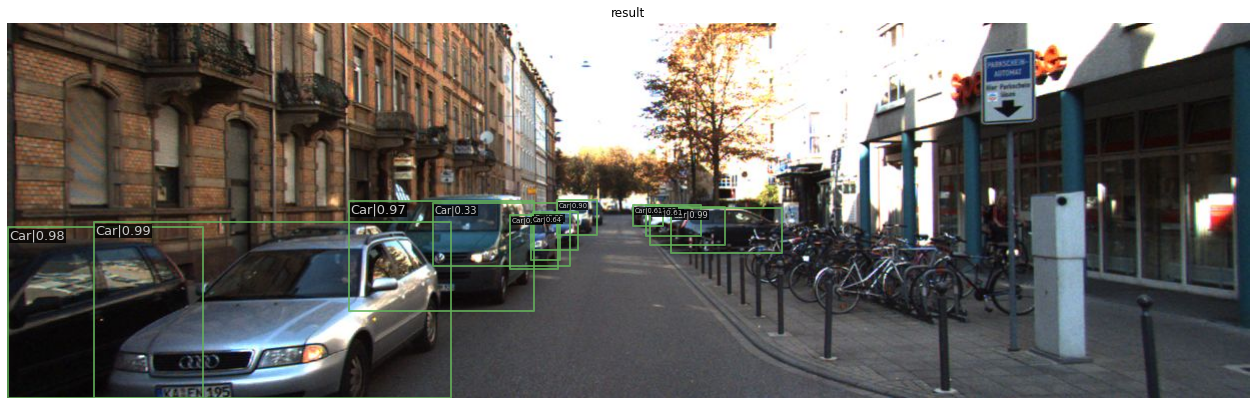

In [ ]:
from mmdet.apis import show_result_pyplot

# BGR Image 사용 
img = cv2.imread('/content/kitti_tiny/training/image_2/000068.jpeg')

model.cfg = cfg

result = inference_detector(model, img)
show_result_pyplot(model, img, result)

## 동영상 활용 inference

In [ ]:
%cd /content
!mkdir /content/data
# 동영상 파일 다운로드
!wget -O /content/data/the_rock_chase.mp4 https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true

/content
--2022-03-19 15:18:57--  https://github.com/chulminkw/DLCV/blob/master/data/video/the_rock_chase.mp4?raw=true
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4 [following]
--2022-03-19 15:18:57--  https://github.com/chulminkw/DLCV/raw/master/data/video/the_rock_chase.mp4
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4 [following]
--2022-03-19 15:18:58--  https://raw.githubusercontent.com/chulminkw/DLCV/master/data/video/the_rock_chase.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.

In [ ]:
CLASSES = ('Car', 'Truck', 'Pedestrian', 'Cyclist')
labels_to_names = {i:k for i, k in enumerate(CLASSES)}
labels_to_names

{0: 'Car', 1: 'Truck', 2: 'Pedestrian', 3: 'Cyclist'}

In [ ]:
def get_detected_img(model, img_arr, score_threshold=0.3):
  '''모델과 원본 이미지, 필터링할 클래스 신뢰도 점수 기준을 입력받아 객체 탐지 inference 결과 이미지 반환'''
  img_arr_copy = img_arr.copy() # img_arr 복사

  bbox_color=(0, 255, 0) # 초록색
  text_color=(0, 0, 255) # 빨간색

  results = inference_detector(model, img_arr) # 객체 탐지 ineference 수행 

  # 80개의 array를 갖는 results를 순회하며, 
  # 개별 2차원 array를 추출하고 이를 바탕으로 이미지에 경계 박스와 신뢰도 점수 표시 
  for class_id, result in enumerate(results):
    if len(result) == 0: # 개별 array가 비었다면 해당 class id로 탐지된 값이 없음 
      continue
    
    # 신뢰도 점수가 score_threshold보다 큰 값만 추출 
    result_filtered = result[np.where(result[:, 4] > score_threshold)]
    
    for i in range(len(result_filtered)): # result_filtered를 순회 
      # 객체 좌표값(경계 박스 좌표값) 추출 
      x_min = int(result_filtered[i, 0]) # 좌상단 x좌표
      y_min = int(result_filtered[i, 1]) # 좌상단 y좌표
      x_max = int(result_filtered[i, 2]) # 우상단 x좌표
      y_max = int(result_filtered[i, 3]) # 우상단 y좌표
      # 경계 박스 그리기 
      cv2.rectangle(img_arr_copy, (x_min, y_min), (x_max, y_max), color=bbox_color, thickness=2)

      class_name = labels_to_names[class_id] # 클래스명 
      confidence_score = result_filtered[i, 4] # 신뢰도 점수 
      caption = f'{class_name}: {confidence_score:.4f}' # 캡션
      # 캡션 달기
      cv2.putText(img_arr_copy, caption, (int(x_min), int(y_min - 7)), cv2.FONT_HERSHEY_SIMPLEX, 0.37, text_color, 1)

  return img_arr_copy # 경계 박스와 캡션이 달린 이미지 반환

In [ ]:
def write_detected_video(model, input_path, output_path, score_threshold):
    '''동영상 파일의 프레임마다 객체 탐지를 수행해 경계 박스와 신뢰도 점수를 표시해 동영상 저장'''
    cap = cv2.VideoCapture(input_path) # 비디오 캡쳐 객체 생성

    codec = cv2.VideoWriter_fourcc(*'XVID') # Codec은 *'XVID'로 설정
    video_fps = cap.get(cv2.CAP_PROP_FPS) # FPS(Frames Per Second)
    video_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH) # 비디오 캡쳐 객체 프레임의 너비
    video_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT) # 비디오 캡쳐 객체 프레임의 높이
    video_size = (round(video_width), round(video_height)) # 비디오 크기 
    # VideoWriter 객체 생성
    video_writer = cv2.VideoWriter(output_path, codec, video_fps, video_size) 

    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # # Frame 갯수
    print('총 프레임 개수:', frame_cnt)

    while True:
        hasFrame, img_frame = cap.read() # 비디오 캡쳐 객체에서 Frame 하나 읽기 
        if not hasFrame: # 처리할 Frame이 없으면 중단
            break
        # 해당 프레임 이미지를 활용해 객체 탐지 inference 수행
        img_frame = get_detected_img(model, img_frame,  score_threshold=score_threshold)
        video_writer.write(img_frame) # 경계 박스를 그린 프레임을 저장 

    video_writer.release() # video_writer 닫기
    cap.release() # cap 닫기

In [ ]:
write_detected_video(model=model, 
                     input_path='/content/data/the_rock_chase.mp4', 
                     output_path='/content/data/the_rock_chase_out1.mp4', 
                     score_threshold=0.4)

총 프레임 개수: 503
